In [ ]:
# finding single and double-positive cells

In [2]:
library(Seurat)
library(dplyr)
library(ggplot2)
library(ggpointdensity)
library(cowplot)
library(viridis)
library(ggbeeswarm)

In [3]:
# dataset 2
sc1 = readRDS('La_Manno_data.rds')
sc1
mtd1 = sc1@meta.data
mtd1[1:2,]

An object of class Seurat 
31017 features across 268469 samples within 1 assay 
Active assay: RNA (31017 features, 0 variable features)
 1 layer present: counts

orig.ident nCount_RNA nFeature_RNA Age  
10X40_3_A_1:CGAGGCACTAGAGAx 10X40       8297      2812         e11.0
10X40_3_A_1:TGTTAAGATCTCTAx 10X40      11389      3327         e11.0
                            CellCycle           CellID                     
10X40_3_A_1:CGAGGCACTAGAGAx 0.0136046231639778  10X40_3_A_1:CGAGGCACTAGAGAx
10X40_3_A_1:TGTTAAGATCTCTAx 0.00193016318652395 10X40_3_A_1:TGTTAAGATCTCTAx
                            Cell_Conc Chemistry ChipID Class        ⋯ Region   
10X40_3_A_1:CGAGGCACTAGAGAx 600       v2        10X40  Gastrulation ⋯ Hindbrain
10X40_3_A_1:TGTTAAGATCTCTAx 600       v2        10X40  Gastrulation ⋯ Hindbrain
                            SampleID SampleName Sample_Index Sex Species Split
10X40_3_A_1:CGAGGCACTAGAGAx 10X40_3  G68        SI-3A-D5     ?   Mm      1    
10X40_3_A_1:TGTTAAGATCTCTAx 10X40_3  G68        SI-3A-D5     ?   Mm      1    
                            Strain Subclass         Tissue   
10X40_3_A_1:CGAGGCACTAGAGAx CD-1   Cardiac mesoderm Hindbrain
10X40_3_A_1:TGTTAAGATCTCTAx CD-1   Cardiac mesoderm Hindbrain

In [4]:
table(mtd1$Age)


 e10.0  e11.0  e12.0  e12.5  e13.0  e13.5  e14.0  e14.5  e15.0  e15.5  e16.0 
 30244  17395  27509   5222   9093  16336   8150  14217  18443   8796  15710 
e16.25  e16.5  e17.0  e17.5  e18.0   e9.0 
  4250  14067  21974  10654  30436  15973 

In [5]:
# cpm-normalize the raw counts
seu = CreateSeuratObject(counts = LayerData(sc1, assay = 'RNA', layer = 'counts'), meta.data = sc1@meta.data)
seu <- NormalizeData(seu, normalization.method = "RC", scale.factor = 1e6)
exp1 = LayerData(seu, assay = 'RNA', layer = 'data') # cpm

Normalizing layer: counts



In [6]:
sum(exp1['Neurog2',]>0)
sum(exp1['Ascl1',]>0)
sum(exp1['Neurog1',]>0)

[1] 27926

[1] 25291

[1] 10514

In [7]:
# get new cell types for A1N2 and N1N2 cases
get_celltype_new <- function(exp0, g1, g2){
    gene1_exp = exp0[g1,]
    gene2_exp = exp0[g2,]
    
    vec1 = rank(gene1_exp)
    vec2 = rank(gene2_exp)
    
    vec1 <- vec1/max(vec1, na.rm = T)
    vec2 <- vec2/max(vec2, na.rm = T)

    id1 = which(vec1>0.7 & vec2>0.7) # dbl-positive
    id2 = which(vec1>0.7 & vec2<=0.7) # neurog2
    id3 = which(vec1<=0.7 & vec2>0.7) # ascl1

    ctypes = rep('none', dim(exp0)[2])
    ctypes[id1] = 'double_positive'
    ctypes[id2] = paste0(g1, '_positive')
    ctypes[id3] = paste0(g2, '_positive')

    return(ctypes)
}

In [8]:
# get cell type labels based on ranked exp bins
seu$celltype_A1N2 = get_celltype_new(exp1, 'Neurog2', 'Ascl1')
seu$celltype_N1N2 = get_celltype_new(exp1, 'Neurog2', 'Neurog1')

In [9]:
# save file
saveids = which(exp1['Neurog2',]>0 | exp1['Ascl1',]>0 | exp1['Neurog1',]>0)
length(saveids)

sce = CreateSeuratObject(counts = LayerData(seu, assay = 'RNA', layer = 'counts')[,saveids], 
                         data = exp1[,saveids], meta.data = seu@meta.data[saveids,])
sce

# save
saveRDS(sce, file = 'La_Manno_A1N1N2.rds')

[1] 51876

An object of class Seurat 
31017 features across 51876 samples within 1 assay 
Active assay: RNA (31017 features, 0 variable features)
 2 layers present: counts, data

In [18]:
gene1_exp = exp1['Neurog2',]
gene2_exp = exp1['Neurog1',]

vec1 = rank(gene1_exp)
vec2 = rank(gene2_exp)

vec1 <- vec1/max(vec1, na.rm = T)
vec2 <- vec2/max(vec2, na.rm = T)

In [27]:
cor(vec1, vec2, method = 'spearman')

[1] 0.1315921

In [28]:
dat = data.frame(m1_exp = log2(1+gene1_exp), m2_exp = log2(1+gene2_exp),
                 m1_rank = vec1, m2_rank = vec2)
dat[1:2,]

m1_exp m2_exp   m1_rank   m2_rank  
P12_NxCLB1_AAACCCAAGGTTCAGG 0      7.979469 0.4777732 0.7609341
P12_NxCLB1_AAACCCACAACTCGAT 0      7.845099 0.4777732 0.7461846

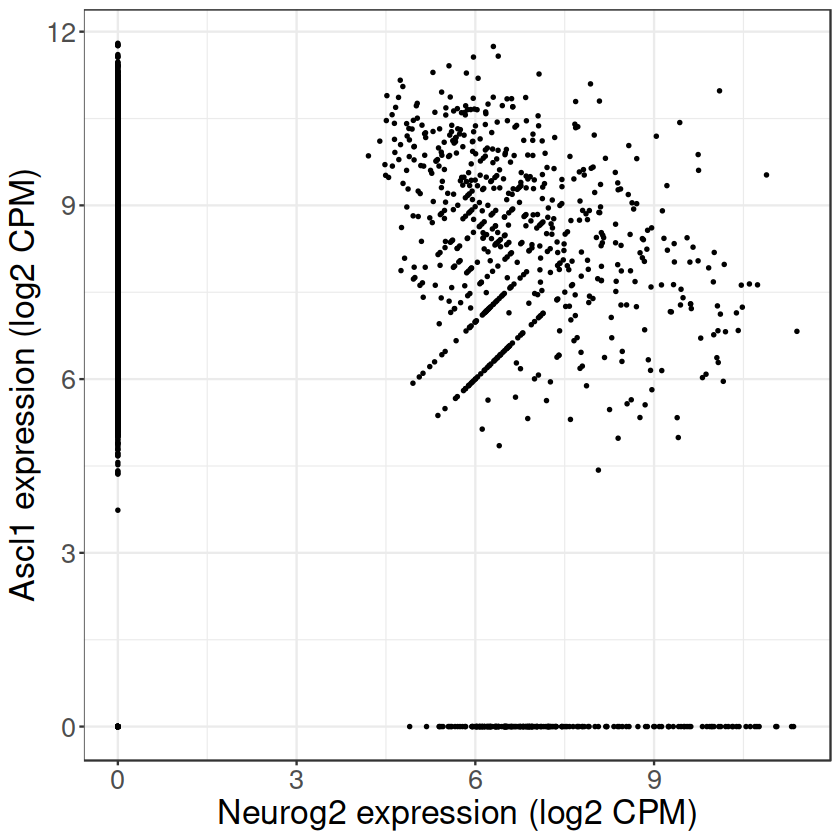

In [29]:
# png('aa-gene-exp-coexp.png', width = 5, height = 5, res = 300, units = 'in')
ggplot(dat, aes(x = m1_exp, y = m2_exp)) +
geom_point(size = 0.5) + theme_bw() + theme(text = element_text(size = 20)) +
xlab('Neurog2 expression (log2 CPM)') + ylab('Ascl1 expression (log2 CPM)')
# dev.off()

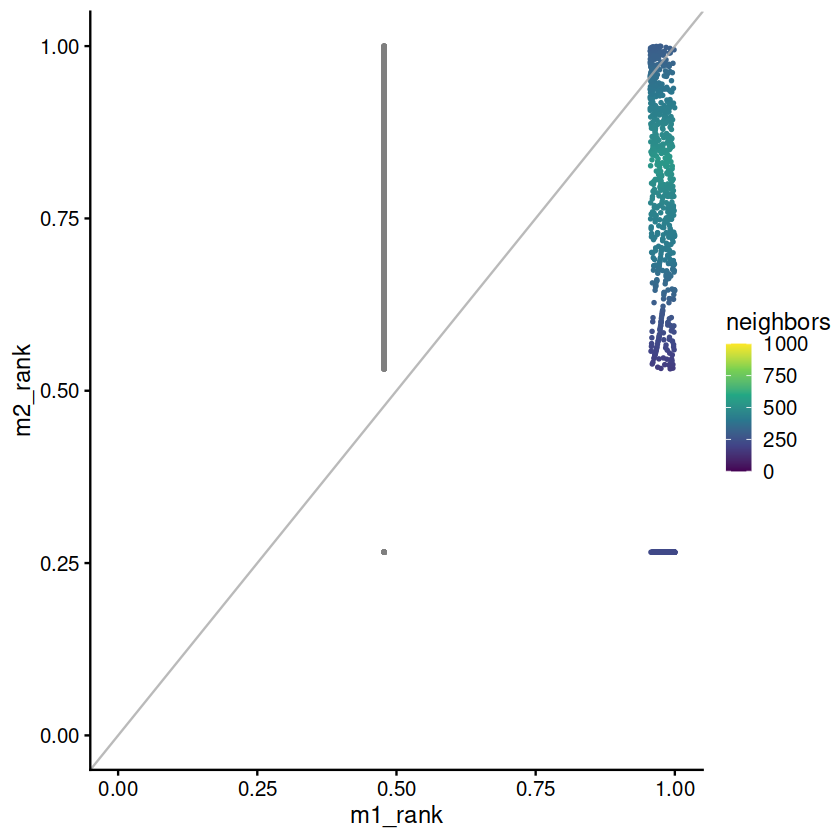

In [93]:
# png(paste0('aa-', g1, '-density-coexp.png'), width = 10, height = 5, res = 300, units = 'in')
# pdf(paste0('aa-hc-', g3, '-density-coexp.pdf'), width = 5, height = 5)

ggplot(dat, aes(x = m1_rank, y = m2_rank)) +
geom_pointdensity(size = 0.5) + scale_color_viridis_c(limits = c(0,1000)) + 
geom_abline(intercept = 0, slope = 1,col = 'darkgray', lwd = 0.5, alpha = 0.8)+
theme_cowplot() + labs(col = 'neighbors') + xlim(0,1) + ylim(0,1)

# dev.off()

In [19]:
id1 = which(vec1>0.7 & vec2>0.7) # dbl-positive
id2 = which(vec1>0.7 & vec2<0.7) # neurog2
id3 = which(vec1<0.7 & vec2>0.7) # ascl1

length(id1)
length(id2)
length(id3)

[1] 5864

[1] 22062

[1] 4650

In [11]:
# cluster 8,10,16,22 for dbl-pos; cluster 32 for neurog2+
table(as.character(mtd1$Subclass[id1]))


                           Angioblast            Anteromedial cerebral pole 
                                    1                                     1 
                        Cajal-Retzius                                Caudal 
                                   23                                     2 
             Cerebellum glutamatergic                        Choroid plexus 
                                    1                                     1 
                         Cortical hem Cortical or hippocampal glutamatergic 
                                   44                                    57 
              Diencephalic roof plate                          Diencephalon 
                                    3                                     9 
           Diencephalon glutamatergic                   Dorsal diencephalon 
                                   19                                    42 
                     Dorsal forebrain                      Dorsal hindbrain

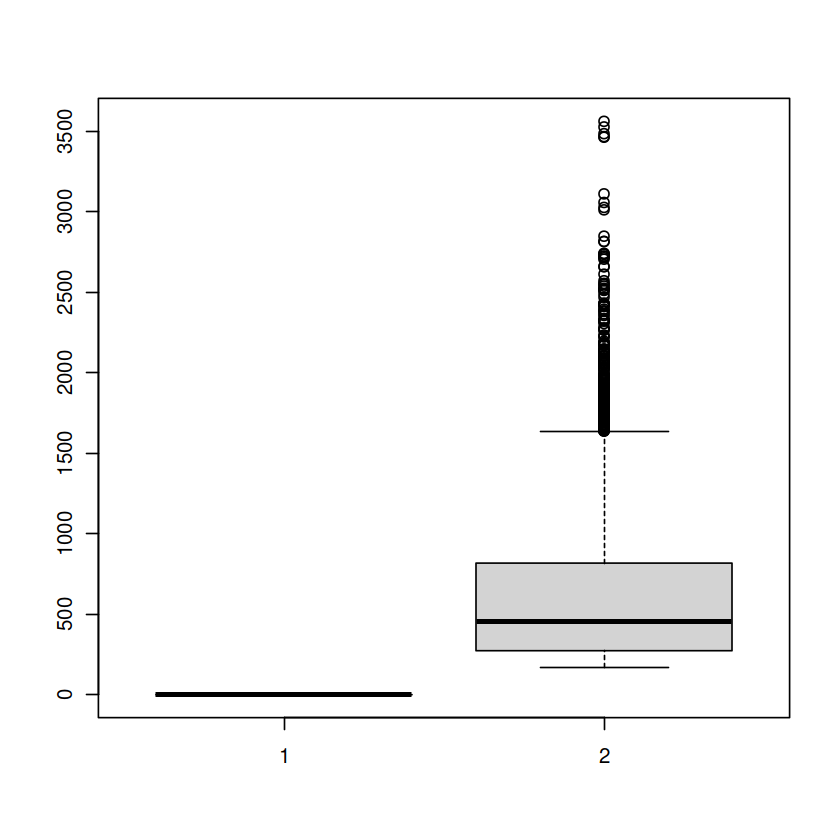

In [96]:
boxplot(exp1['Neurog2', id3], exp1['Ascl1', id3])

In [12]:
# Alex's target genes
alex = c('Bcl11a', 'Bcl11b', 'Nhlh1', 'Nhlh2', 'Sox2', 'Sox9', 'Gfap',
        'Pax6', 'Prom1', 'Foxj1', 'Rbfox3', 'Nes', 'Hopx', 'Dcx',
        'Bdnf', 'Pdgfra', 'S100b')
length(alex)

[1] 17

[1] "Nes"

[1] 51341

[1] 1918

[1] 5528

[1] 7509

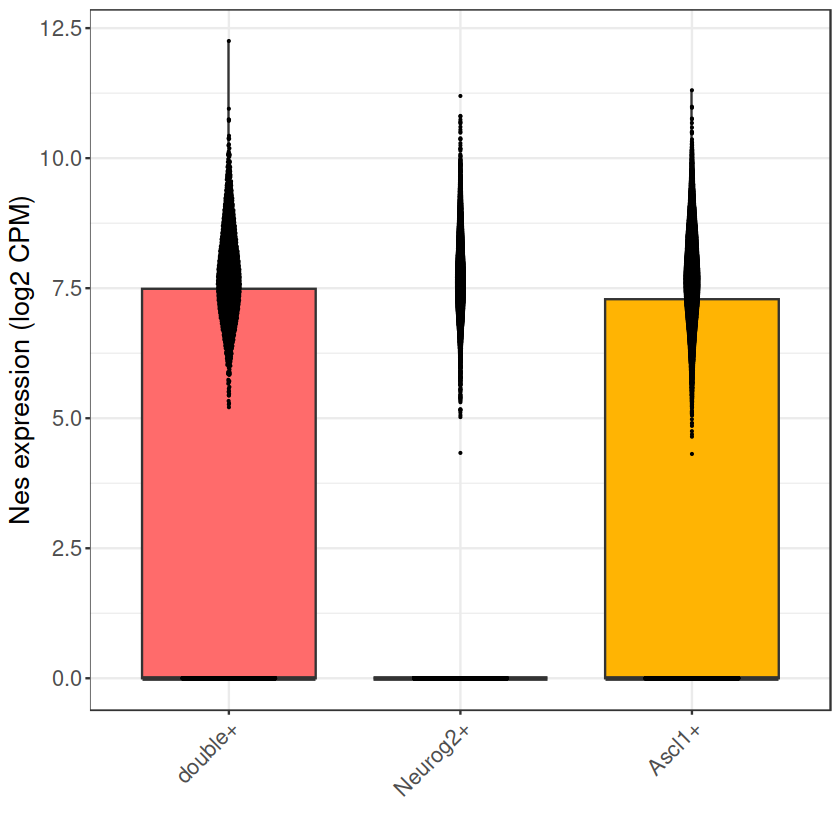

In [13]:
# other coexpressing genes
currgene = alex[12]
currgene
sum(exp1[currgene,]>0)

# no. of cells with >0 exp in each case
sum(exp1[currgene, id1]>0)
sum(exp1[currgene, id2]>0)
sum(exp1[currgene, id3]>0)

exp_vec = exp1[currgene,]
vec3 = rank(exp_vec)
vec3 <- vec3/max(vec3, na.rm = T)
plotdf = data.frame(gene = currgene, 
                    ctype = c(rep('double+', length(id1)), rep('Neurog2+', length(id2)), rep('Ascl1+', length(id3))),
                    exp = c(log2(1+exp_vec[id1]), log2(1+exp_vec[id2]), log2(1+exp_vec[id3])),
                    rank_exp = c(vec3[id1], vec3[id2], vec3[id3]))
plotdf$ctype = factor(plotdf$ctype, levels = c('double+', 'Neurog2+', 'Ascl1+'))

# png(paste0('aa-', currgene, '-exp.png'), width = 3.5, height = 5, res = 300, units = 'in')
ggplot(plotdf, aes(x = ctype, y = exp, fill = ctype)) + 
geom_boxplot(outlier.shape = NA) + geom_quasirandom(size = 0.1, width = 0.2) + theme_bw() +
theme(text = element_text(size = 16), axis.text.x = element_text(angle = 45, hjust = 1), legend.position = 'none') +
xlab('') + ylab(paste0(currgene, ' expression (log2 CPM)')) + scale_fill_manual(values = c('#ff6b6b', '#48bf91', '#ffb403'))
# dev.off()

In [20]:
# which genes show the pattern we want? (apart from Alex's targets)
# expr in double-positive > single-positive cells
options(warn = -1)
allgenes = setdiff(rownames(exp1), c('Neurog2', 'Neurog1'))
length(allgenes)

# get row ranks
r1 = matrixStats::rowRanks(as.matrix(exp1[allgenes,c(id1,id2,id3)]))
r1 <- r1/dim(exp1)[2]

pb = txtProgressBar(min = 0, max = length(allgenes), initial = 0)
gset = c()

for(ii in 1:length(allgenes)){
    vec3 = r1[ii,]

    m1 = mean(vec3[1:length(id1)])
    m2 = mean(vec3[(length(id1)+1):(length(id1)+length(id2))])
    m3 = mean(vec3[(length(id1)+length(id2)+1):(length(id1)+length(id2)+length(id3))])
    
    if(m1>m2 & m1>m3){
        gset = c(gset, allgenes[ii])
    }
    setTxtProgressBar(pb, ii)
}

length(gset)

[1] 31015

[1] 5978

In [21]:
# wow, 10% follow our trend
pb = txtProgressBar(min = 0, max = length(gset), initial = 0)

dfnew = data.frame(gene = gset, dbl_exp = 0, gene1_exp = 0, 
                   gene2_exp = 0, retain = 0)

r2 = log2(1+exp1[gset,])

for(ii in 1:length(gset)){
    vec3 = r2[ii,]

    m1 = mean(vec3[id1])
    m2 = mean(vec3[id2])
    m3 = mean(vec3[id3])    

    dfnew$dbl_exp[ii] = m1
    dfnew$gene1_exp[ii] = m2
    dfnew$gene2_exp[ii] = m3
    
    if(m1>1.5*m2 & m1>1.5*m3 & m1>2){
        dfnew$retain[ii] = 1
    }
    setTxtProgressBar(pb, ii)
}
dfnew <- dfnew %>% arrange(-retain, -dbl_exp)

sum(dfnew$retain)
dfnew[1:2,]

[1] 8

gene    dbl_exp  gene1_exp gene2_exp retain
1 Zc3h12c 4.741973 2.048640  2.765333  1     
2 Rhbdl3  4.646966 2.205161  2.126560  1

In [22]:
dfnew$gene[dfnew$retain==1]

[1] "Zc3h12c" "Rhbdl3"  "Dll1"    "Eomes"   "Heg1"    "Sstr2"   "Abcd2"  
[8] "Tfap2c"

In [23]:
# df for saving
write.table(dfnew, file = 'la_manno_neurog2_neurog1_geneset.csv', sep = ',',
           row.names = F, col.names = T, quote = F)

In [42]:
# show avg exp and pct expressed
geneset = rev(c('Nes', 'Thrsp', 'Gpc5', 'Efhd2', 'Gpc4', 'Gli2', 'Adarb1'))
plotdf2 = c()

for(ii in 1:length(geneset)){
    currgene = geneset[ii]
    exp_vec = exp1[currgene,]
    
    temp = data.frame(gene = currgene, 
                        ctype = c('double+', 'Neurog2+', 'Ascl1+'),
                        log2_exp = c(mean(log2(1+exp_vec[id1])), mean(log2(1+exp_vec[id2])), mean(log2(1+exp_vec[id3]))),
                        pct_exp = c(sum(exp1[currgene, id1]>0)/length(id1), 
                                sum(exp1[currgene, id2]>0)/length(id2), sum(exp1[currgene, id3]>0)/length(id3)))
    plotdf2 = rbind(plotdf2, temp) 
}

plotdf2$ctype = factor(plotdf2$ctype, levels = c('double+', 'Neurog2+', 'Ascl1+'))
plotdf2$gene = factor(plotdf2$gene, levels = geneset)
plotdf2[1:3,]

gene   ctype    log2_exp  pct_exp  
1 Adarb1 double+  0.6800809 0.1255230
2 Adarb1 Neurog2+ 0.6340548 0.1023018
3 Adarb1 Ascl1+   0.7318099 0.1314126

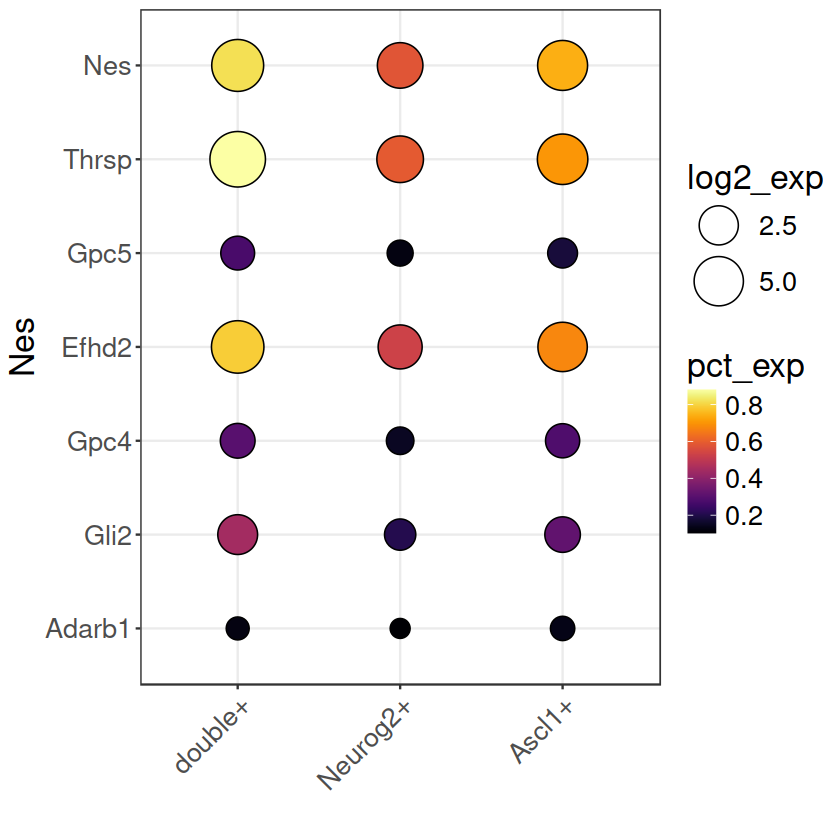

In [45]:
# png('aa-geneset-exp-pct.png', width = 5, height = 6, res = 300, units = 'in')
ggplot(plotdf2, aes(x = ctype, y = gene, label = round(pct_exp*100)/100)) +  
geom_point(shape = 21, color = 'black', aes(fill = pct_exp, size = log2_exp)) + theme_bw() + 
# geom_text(size = 6, hjust = -0.25, vjust = -2) + 
theme(text = element_text(size = 20), axis.text.x = element_text(angle = 45, hjust = 1)) +
xlab('') + ylab(currgene) + scale_fill_viridis(option = 'B') +
scale_size_continuous(breaks = c(0, 2.5, 5, 7.5, 10, 12.5, 15), range = c(5, 15)) 
# dev.off()